In [1]:
%matplotlib widget
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
from scipy import signal

# import datashader as ds
# import datashader.transfer_functions as tf
import pandas as pd
import numpy as np
import pynapple as nap


import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

na = np.array
def detect_low_events(signal, window_size=5000, threshold_std=5, min_separation=2000,dt=0.0004):
    """
    Detects events in the signal that are below the mean - (threshold_std * std_dev),
    extracts windows around the peaks using the Hilbert transform, ensuring minimum separation between events.

    Parameters:
    signal (np.array): 1D array of signal data.
    window_size (int): Number of samples to include in each window.
    threshold_std (float): Threshold in terms of standard deviations.
    min_separation (int): Minimum number of points between consecutive events.
    
    Returns:
    list of np.array: Extracted event windows.
    """
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    threshold = mean_val - (threshold_std * std_val)
    
    # Find indices where signal is below the threshold
    event_indices = np.where(signal < threshold)[0]
    
    # Ensure events are at least min_separation apart
    filtered_indices = []
    last_idx = -min_separation
    for idx in event_indices:
        if idx - last_idx >= min_separation:
            filtered_indices.append(idx)
            last_idx = idx
    
    # Compute Hilbert transform and envelope
    analytic_signal = scipy.signal.hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    # Extract windows around the peak of the envelope
    windows = []
    intervals= []
    for idx in filtered_indices:
        peak_idx = idx + np.argmax(envelope[idx:idx + window_size])
        start = max(0, peak_idx - window_size // 2)
        end = min(len(signal), peak_idx + window_size // 2)
        windows.append(signal[start:end])
        intervals.append([float(start)*dt,float(end)*dt])
    
    return windows,intervals


In [2]:
file_table =pd.read_csv('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/Horiz_slices_files - Sheet1.csv')

In [3]:
file_names = na(file_table['file_name_copy'])
file_name = file_names[0]

In [8]:
file_names[1:]

array(['/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T11-43-47McsRecording.h5',
       '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T10-29-29McsRecording.h5',
       '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-02T13-31-47McsRecording.h5',
       '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-02T12-42-00McsRecording.h5'],
      dtype=object)

In [18]:
def load_data(file_name):
    fs=10000
    channel_raw_data = McsPy.McsData.RawData(file_name)    
    # get channel IDs
    channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
    channel_ids = np.hstack(channel_ids)
    channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
    analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
    analog_stream_0_data = analog_stream_0.channel_data
    adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
    #get offsets
    offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]
    
    y = na(analog_stream_0_data)
    # correct to Volts
    y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
    x =np.arange(0,len(y[0,:]))/fs

    return x,y


In [9]:
%%time
fs=10000
for file_name in file_names[1:]:
    channel_raw_data = McsPy.McsData.RawData(file_name)    
    # get channel IDs
    channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
    channel_ids = np.hstack(channel_ids)
    channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
    analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
    analog_stream_0_data = analog_stream_0.channel_data
    
    #
    adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
    #get offsets
    offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]
    
    y = na(analog_stream_0_data)
    # correct to Volts
    y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
    x =np.arange(0,len(y[0,:]))/fs

    # import pynapple as nap
    # preselect elecrodes where interesting things happen
    # Filter LFPs

    downsample_factor = 4
    fs_new = fs // downsample_factor  # New sampling rate (2500 Hz)
    data_to_store = []
    
    for i in range(252):
        y_down = signal.decimate(y[i,:], downsample_factor, ftype="fir")
        tsd = nap.Tsd(t=x[::downsample_factor], d=y_down,columns = np.arange(0,y_down.shape[0]))
        # get only LFP ignore all spikes 
        data_band = nap.apply_bandpass_filter(tsd, cutoff=(.1, 200.0), fs=fs_new,mode='butter', order=6)
        extr_thr = np.sum(data_band < (np.mean(data_band)-np.std(data_band))*7)
        if extr_thr>0:
            event_windows,intervals = detect_low_events(data_band.d,dt=(1/fs_new))
            data_to_store.append([file_name,channel_labels[i],event_windows,intervals])
        # else:
            
        # extra_threhsold.append()
    # results = pd.DataFrame(data_to_store)
    results = pd.DataFrame(data_to_store,columns=['file_name','electrode','events','time_window'])

    results.to_csv(file_name.split('.')[0]+'.csv')
    # break

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 9004000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 12141000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 6001000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": sh

'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T13-29-27McsRecording.csv'

In [3]:
# Create a figure
def get_axes():
    fig, axs = plt.subplots(16, 16, figsize=(8, 8),dpi=200)
    letters = ['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
    # Set the labels for each subplot
    labels = [
        [f"{letters[j]}{i + 1}" for j in range(16)] for i in range(16)
    ]

    # Plot circles with text in each subplot
    ax_dict = {}
    for i in range(16):
        for j in range(16):
            ax = axs[i, j]
            ax.axis('off')
#             circle = patches.Circle((0.5, 0.5), radius=0.4,facecolor=[1,1,1],edgecolor='skyblue')#, color='skyblue')
#             ax.add_patch(circle)
            ax_dict[labels[i][j]] =ax
    return fig, ax_dict

In [66]:
results = pd.DataFrame(data_to_store,columns=['file_name','electrode','events','time_window'])


In [82]:
np.min(r['events'])

np.float64(-2.5269405476538337e-05)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


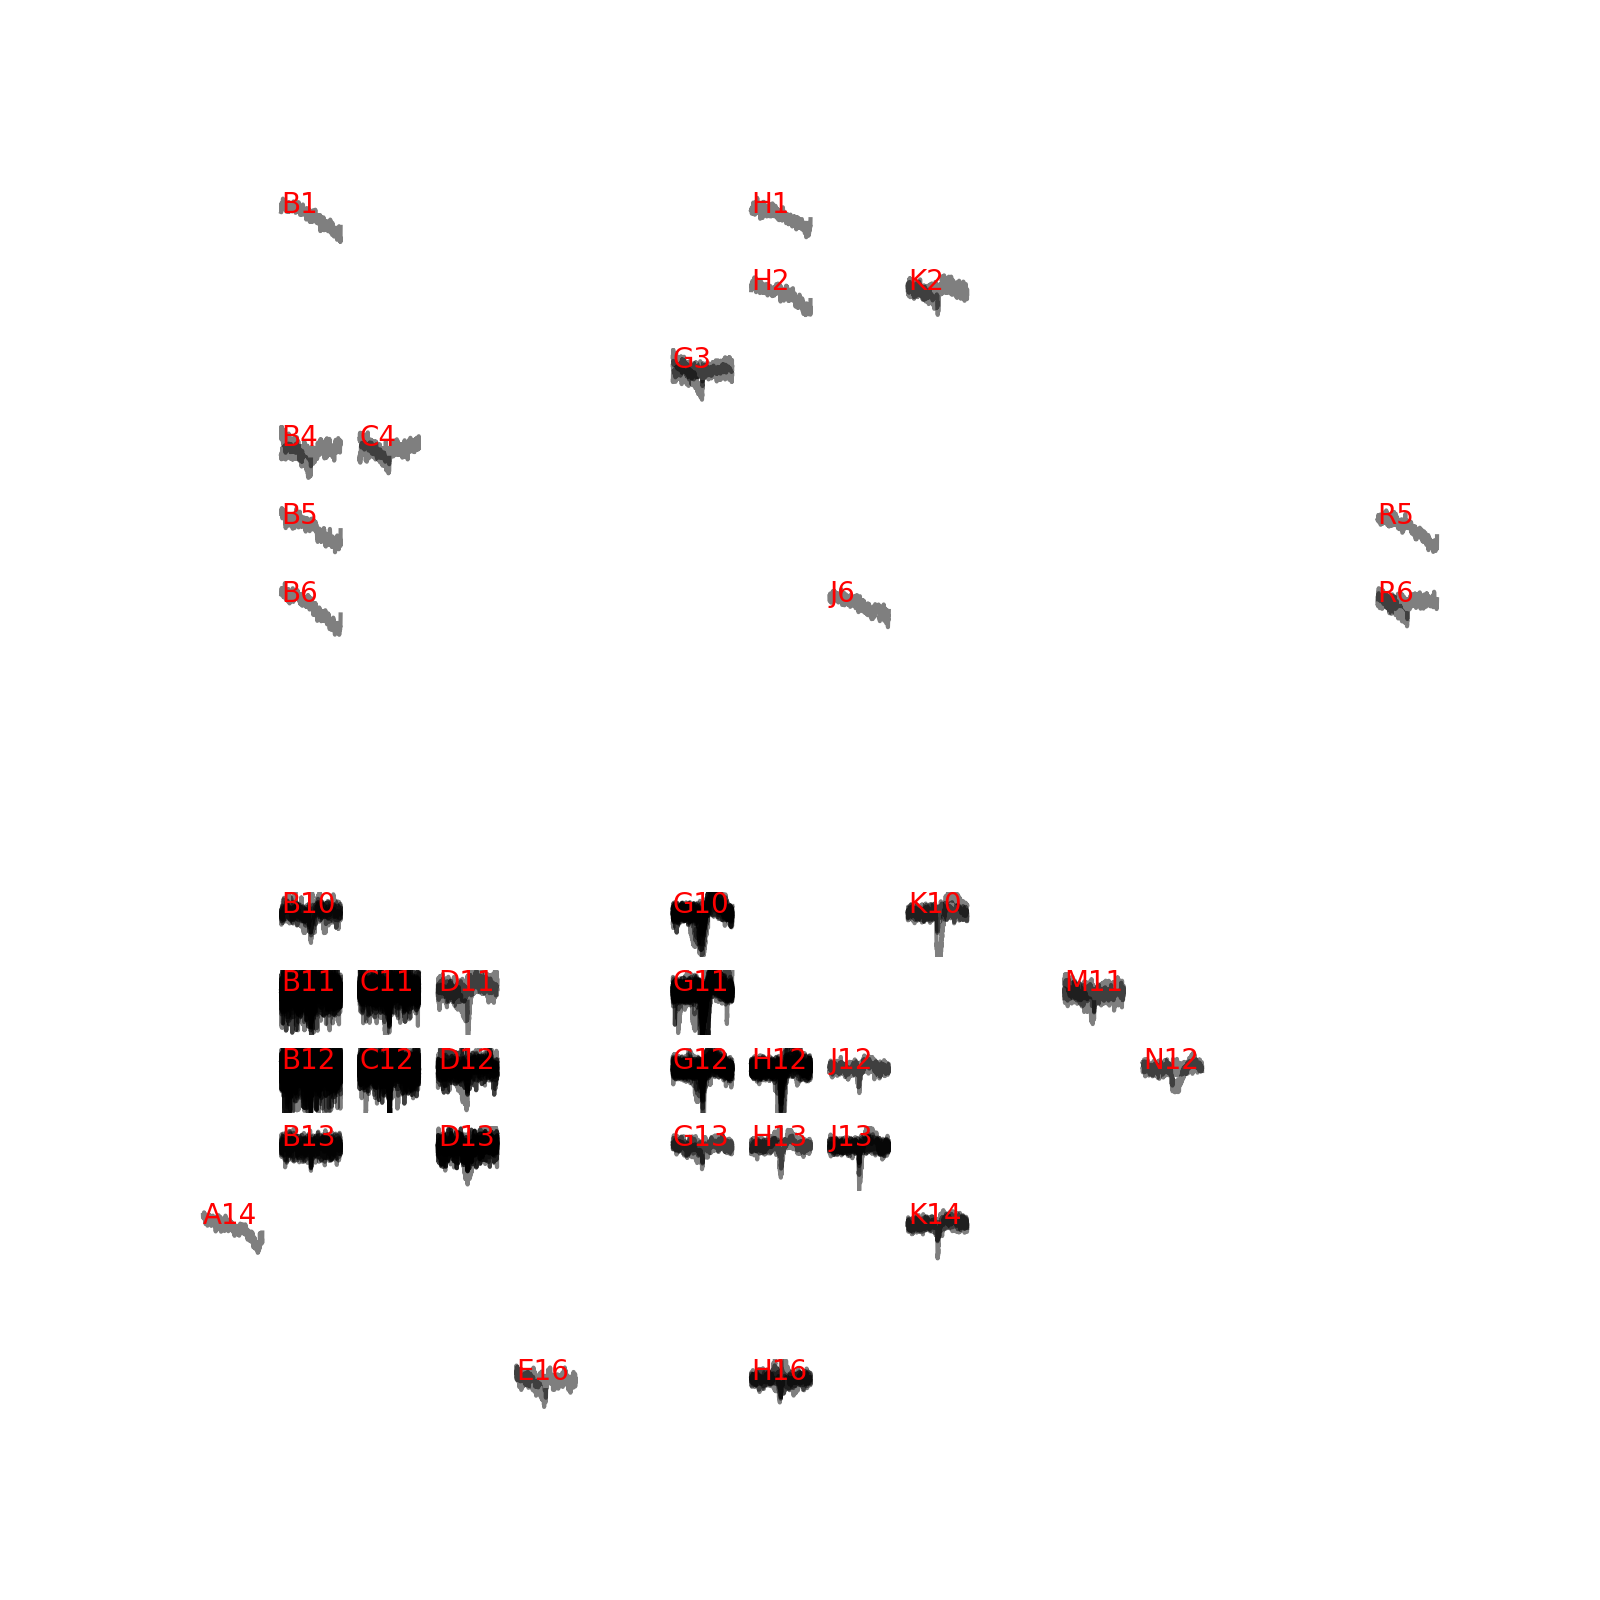

In [84]:
fig,ax = get_axes()
for index,r in results.iterrows():
    [ax[r['electrode']].plot(e,'k',alpha=0.5) for e in r['events']]
    ax[r['electrode']].text(0,0,r['electrode'],color='r')
    ax[r['electrode']].set_ylim([-2.5269405476538337e-05,1.1763198696064663e-05])

In [4]:
proc_data = ['/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-02T12-42-00McsRecording.csv',
'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-02T13-31-47McsRecording.csv',
'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T10-29-29McsRecording.csv',
'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T11-43-47McsRecording.csv'
'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T13-29-27McsRecording.csv']

In [55]:
avg_event_n = []

for proc_data_ in proc_data:
    procLFP = pd.read_csv(proc_data_)
    procLFP.columns ='idx','file_name','electrode','events','time_window'
    n_events = []
    for index,r in procLFP.iterrows():
        n_events.append(len(r['time_window']))
    avg_event_n.append(np.mean(n_events))
    

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


<Axes: >

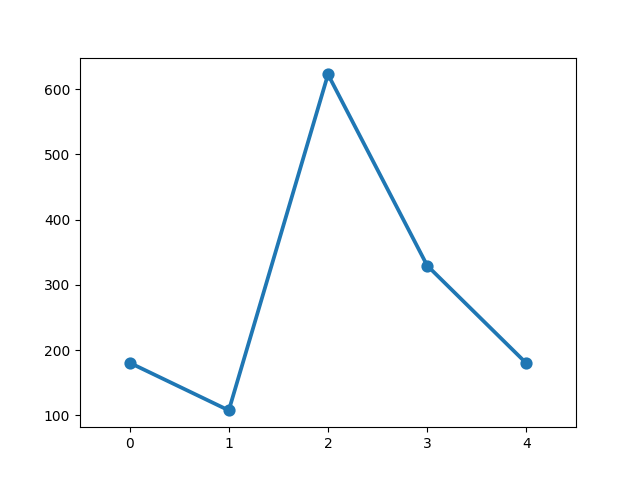

In [60]:
plt.figure()
sns.pointplot(avg_event_n)


In [5]:
procLFP = pd.read_csv('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/horizontal_slices/2024-12-03T10-29-29McsRecording.csv')

In [6]:
procLFP.columns ='idx','file_name','electrode','events','time_window'


In [19]:
x,y, = load_data(procLFP['file_name'][0])

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 12141000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [11]:
file_name = procLFP['file_name'][0]
channel_raw_data = McsPy.McsData.RawData(file_name)    
# get channel IDs
channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
channel_ids = np.hstack(channel_ids)
channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 12141000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [16]:
y = analog_stream_0#get_channel_sample_timestamps(5,10,15)

In [17]:
y

(array([1000, 1100, 1200, 1300, 1400, 1500]), <Unit('microsecond')>)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


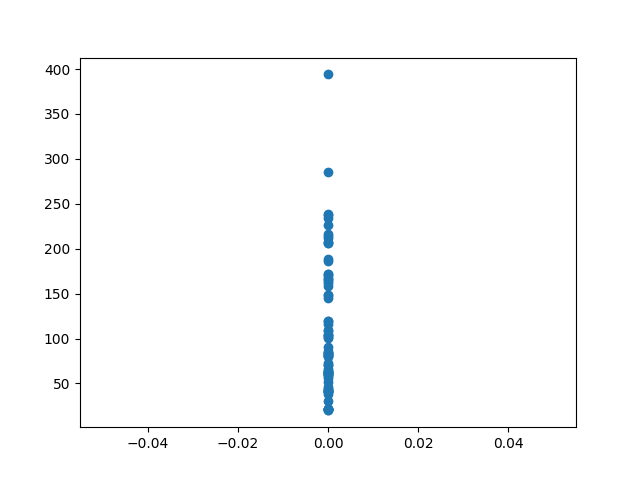

In [38]:
# fig,ax = get_axes()
plt.figure()
n_events = []
for index,r in procLFP.iterrows():
    n_events.append(len(r['time_window']))
    # [ax[r['electrode']].plot(0,len(e),'k',alpha=0.5) for e in]

    # ax[r['electrode']].text(0,0,r['electrode'],color='r')
    # ax[r['electrode']].set_ylim([-2.5269405476538337e-05,1.1763198696064663e-05])


In [49]:
procLFP

,idx,file_name,electrode,events,time_window,n
0,0,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,H15,"[array([-2.25260206e-06, -3.23132315e-06, -3.8...","[[29.9612, 31.9612]]",20
1,1,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,E13,"[array([ 4.58299748e-06, 3.90438271e-06, 3.4...","[[30.137600000000003, 32.1376]]",31
2,2,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,D16,"[array([-2.19314322e-06, -1.16601225e-06, -4.8...","[[131.7464, 133.7464], [227.936, 229.936]]",42
3,3,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,F11,"[array([-4.05803347e-06, -4.20061959e-06, -4.1...","[[4.5044, 6.5044], [8.467600000000001, 10.4676...",101
4,4,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,F15,"[array([1.63902470e-06, 1.63101359e-06, 1.8221...","[[85.4264, 87.4264]]",20
...,...,...,...,...,...,...
75,75,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,R15,"[array([ 4.77523534e-06, 4.53384698e-06, 4.6...","[[95.59320000000001, 97.59320000000001], [599....",59
76,76,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,M15,"[array([4.20262506e-06, 5.42250866e-06, 6.3915...","[[346.528, 348.528], [594.6084000000001, 596.6...",60
77,77,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,L16,"[array([3.44539722e-06, 3.67768741e-06, 3.4868...","[[313.97200000000004, 315.97200000000004], [41...",394
78,78,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,K15,"[array([ 5.64031393e-06, 5.57898632e-06, 5.8...","[[93.706, 95.706], [421.0812, 423.0812], [477....",285


In [48]:
procLFP['n'] = n_events

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


<Axes: >

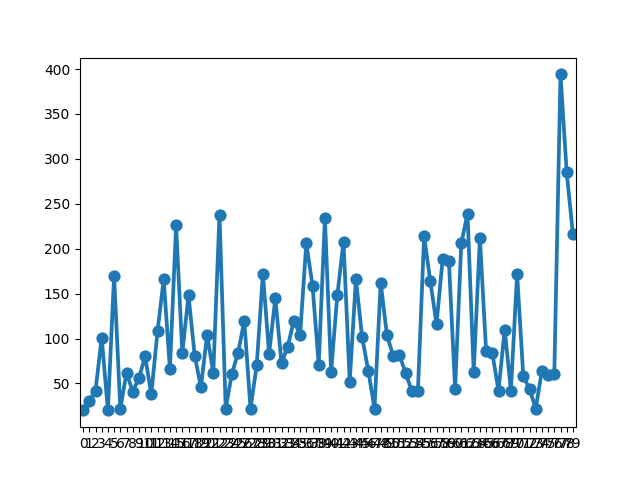

In [44]:
import seaborn as sns
plt.figure()
sns.pointplot(data=n_events)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


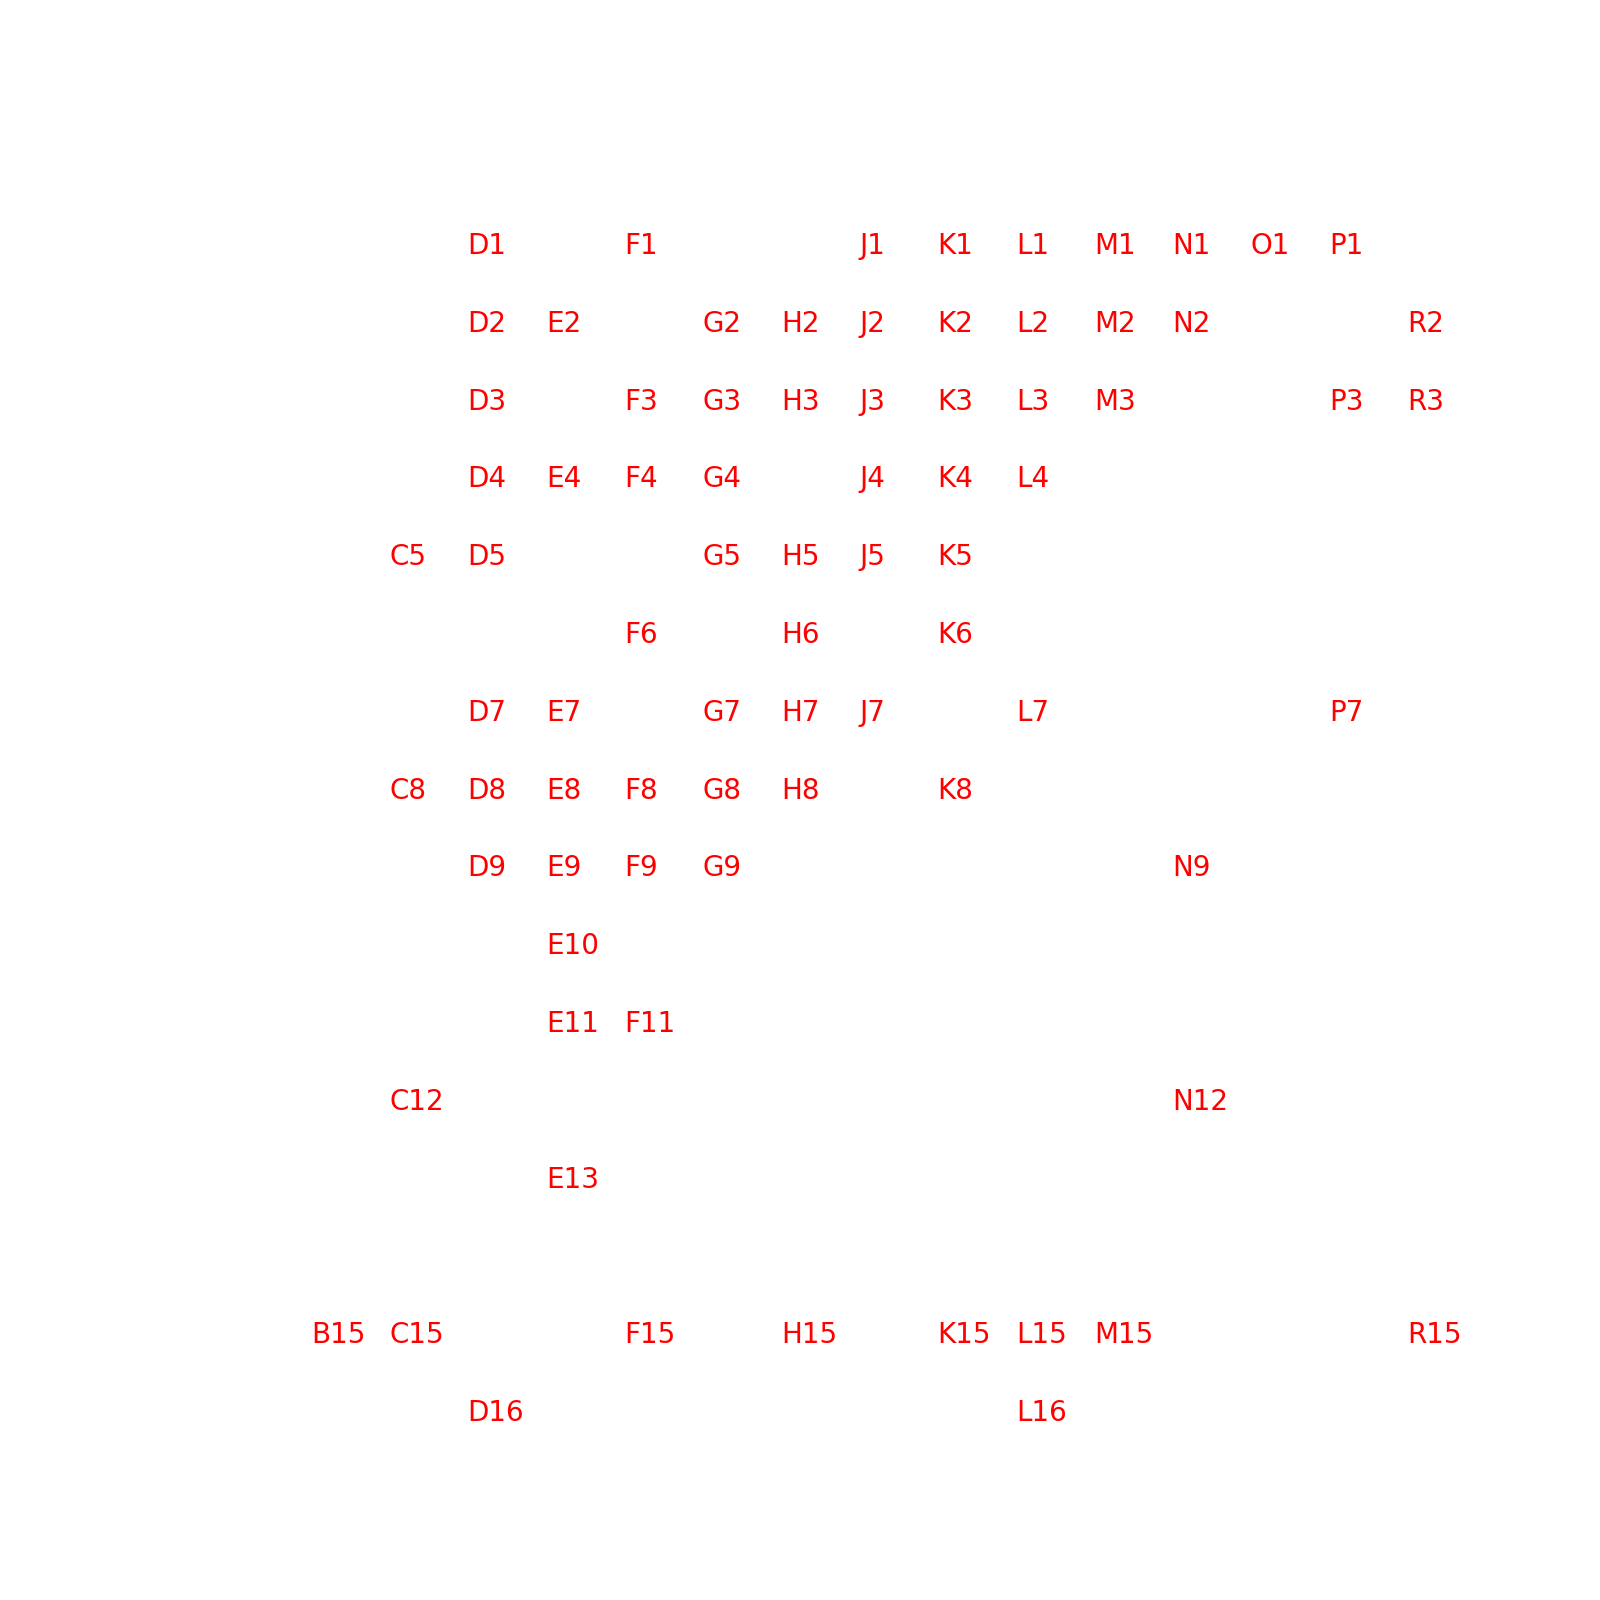

In [28]:
fig,ax = get_axes()
for index,r in procLFP.iterrows():
    [ax[r['electrode']].plot(e,'k',alpha=0.5) for e in r['events']]
    # ax[r['electrode']].text(0,0,r['electrode'],color='r')
    # ax[r['electrode']].set_ylim([-2.5269405476538337e-05,1.1763198696064663e-05])
